In [ ]:
'''
Required Librabreis to Run below the code

python=3.6.8, tensorflow==1.14 and keras==2.2.5


Steps : 

1. Download sd_keras from below the link
    https://github.com/pierluigiferrari/ssd_keras

2. Open Jupyter notebook from above the download code

3. Download the DataSet Used is Pascal VOC2007 dataset:
    http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

In [2]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

In [3]:
img_height = 300 
img_width = 300 
img_channels = 3 
mean_color = [123, 117, 104] 
swap_channels = [2, 1, 0] #BGR instead of RGB
n_classes = 20 
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] 
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] 
two_boxes_for_ar1 = True #used in anchorboxes.py. used for next_scale 
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [4]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

In [7]:
# Parse the image and label lists for the training and validation datasets. This can take a while.
VOC_2007_images_dir      = 'C:/Users/bmi_cims/Downloads/VOC/JPEGImages/'

VOC_2007_annotations_dir      = 'C:/Users/bmi_cims/Downloads/VOC/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = 'C:/Users/bmi_cims/Downloads/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = 'C:/Users/bmi_cims/Downloads/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/val.txt'

VOC_2007_trainval_image_set_filename = 'C:/Users/bmi_cims/Downloads/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = 'C:/Users/bmi_cims/Downloads/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

Processing image set 'test.txt': 100%|█████████████████████████████████████████████| 4952/4952 [00:50<00:00, 98.30it/s]


In [9]:
batch_size = 16

In [10]:
# Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

In [11]:
model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)




Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

# Encoding the Group Truth Layer
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,  # IOU : Overlapping of Default box and GroundTruth box is 0.5
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

# Dividing the data into Batches and generating data Augmentation
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [13]:
# number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset: ", train_dataset_size)
print("Number of images in the validation dataset:  ", val_dataset_size)

Number of images in the training dataset:  5011
Number of images in the validation dataset:   4952


In [17]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(train_generator)

i = 10 # Which batch item to look at

print("Image:", batch_filenames[i])

print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))   # Ground truth Box of the image


'''
In below the value there are two grouth truth box for the image 009839.jpg
The object class for the below the image is 7 (car)

Image: C:/Users/bmi_cims/Downloads/VOC/JPEGImages/009839.jpg
Ground truth boxes:

[[  7 160 159 369 279]
 [  7 422 152 469 207]]


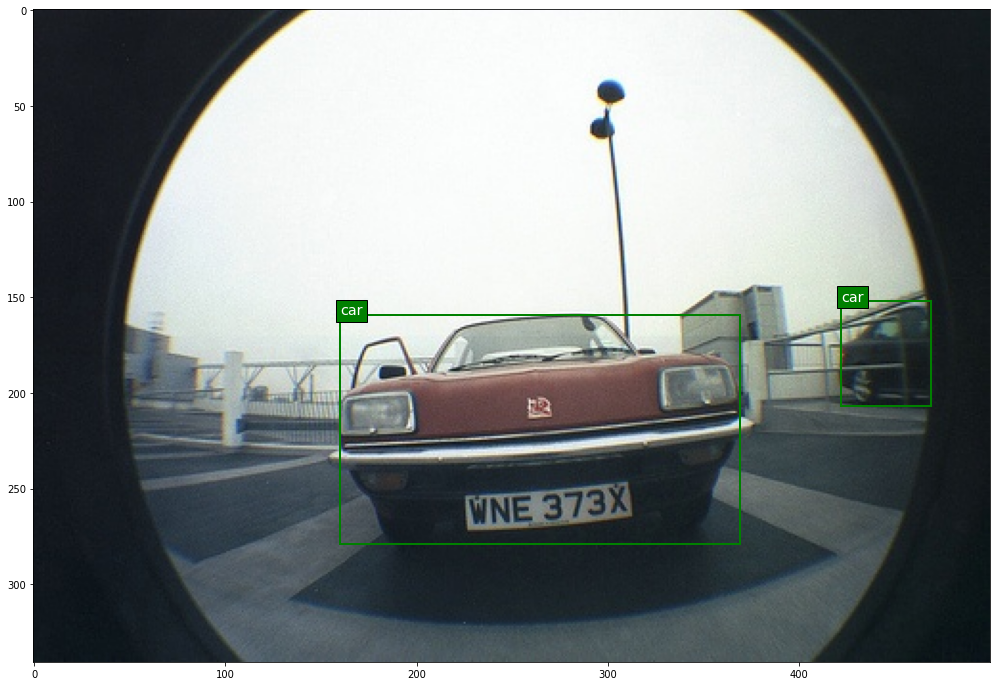

In [18]:
# 5: Draw the predicted boxes onto the image
import matplotlib.pyplot as plt

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

#plt.plot()

#plotting groundtrithbox
for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})